In [1]:
"""Implementation of k-means clustering algorithm.
These functions are designed to work with cartesian data points
"""
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
def convert_to_2d_array(points):
    """
    Converts `points` to a 2-D numpy array.
    """
    points = np.array(points)
    if len(points.shape) == 1:
        points = np.expand_dims(points, -1)
    return points
def visualize_clusters(clusters):
    """
    Visualizes the first 2 dimensions of the data as a 2-D scatter plot.
    """
    plt.figure()
    for cluster in clusters:
        points = convert_to_2d_array(cluster)
        if points.shape[1] < 2:
            points = np.hstack([points, np.zeros_like(points)])
        plt.plot(points[:,0], points[:,1], 'o')
    plt.show()

def DTW(points,centroid):
    errors = np.zeros((len(points),))
    for i in range(len(points)):
        errors[i]=DTWDistance(points[i],centroid)
    return errors

def DTWDistance(s1,s2):
        '''
        Calculates dynamic time warping Euclidean distance between two
        sequences. Option to enforce locality constraint for window w.
        '''
        DTW={}
        w=None
        if w:
            w = max(w, abs(len(s1)-len(s2)))

            for i in range(-1,len(s1)):
                for j in range(-1,len(s2)):
                    DTW[(i, j)] = float('inf')

        else:
            for i in range(len(s1)):
                DTW[(i, -1)] = float('inf')
            for i in range(len(s2)):
                DTW[(-1, i)] = float('inf')

        DTW[(-1, -1)] = 0

        for i in range(len(s1)):
            if w:
                for j in range(max(0, i-w), min(len(s2), i+w)):
                    dist= (s1[i]-s2[j])**2
                    DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            else:
                for j in range(len(s2)):
                    dist= (s1[i]-s2[j])**2
                    DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
        #print("DWT",np.sqrt(DTW[len(s1)-1, len(s2)-1]))
        return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def SSE(points):
    """
    Calculates the sum of squared errors for the given list of data points.
    """
    points = convert_to_2d_array(points)
    centroid = np.mean(points, 0)
    #errors= DTWDistance(points,centroid)
    errors = np.linalg.norm(points-centroid, ord=2, axis=1)
    #print("errors",type(errors))
    return np.sum(errors)    




def kmeans(points, k=2, epochs=1, max_iter=5, verbose=False):
    """
    Clusters the list of points into `k` clusters using k-means clustering
    algorithm.
    """
    points = convert_to_2d_array(points)
    #print("points_nit",points)
    assert len(points) >= k, "Number of data points can't be less than k"
    best_sse = np.inf
    for ep in range(epochs):
        print("epochs",ep)
        # Randomly initialize k centroids
        ##np.random.shuffle(points)
        centroids = points[0:k, :]
        last_sse = np.inf
        for it in range(max_iter):
            print("iter",it)
            # Cluster assignment
            clusters = [None] * k
            for p in points:
                
                index = np.argmin(DTW(centroids,p))
               
                
                if clusters[index] is None:
                    clusters[index] = np.expand_dims(p, 0)
                else:
                    clusters[index] = np.vstack((clusters[index], p))
            # Centroid update
            
            centroids=[]
            for c in clusters:
                if c is not None:
                    centroids.append(np.mean(c,0))
            #centroids = [np.mean(c, 0) for c in clusters]
            # SSE calculation
            #sse = np.sum([SSE(c) for c in clusters])
            ssel=[]
            for c in clusters:
                if c is not None:
                    ssel.append(SSE(c))
            sse = np.sum(ssel)
            gain = last_sse - sse
            if verbose:
                print((f'Epoch: {ep:3d}, Iter: {it:4d}, '
                       f'SSE: {sse:12.4f}, Gain: {gain:12.4f}'))
            # Check for improvement
            if sse < best_sse:
                best_clusters, best_sse = clusters, sse
        # Epoch termination condition
            if np.isclose(gain, 0, atol=0.00001):
                break
            last_sse = sse
    return best_clusters
def bisecting_kmeans(points, k, epochs=10, max_iter=100, verbose=False):
    """
    Clusters the list of points into `k` clusters using bisecting k-means
    clustering algorithm. Internally, it uses the standard k-means with k=2 in
    each iteration.
    """
    points = convert_to_2d_array(points)
    clusters = [points]
    #print("len::clusters",clusters)
    while len(clusters) < k:
        
        max_sse_i = np.argmax([SSE(c) for c in clusters])
        #print("max_sse_i",max_sse_i)
        cluster = clusters.pop(max_sse_i)
        print("len",len(clusters))
        two_clusters = kmeans(cluster, 2, epochs=epochs, max_iter=max_iter, verbose=verbose)
        clusters.extend(two_clusters)
    return clusters


user 0
user 1
video  0
For n_clusters = 2 The average silhouette_score is : 0.24749884074764691
For n_clusters = 3 The average silhouette_score is : 0.24737129524893117
For n_clusters = 4 The average silhouette_score is : 0.21101787369712968
For n_clusters = 5 The average silhouette_score is : 0.1802239073556104
For n_clusters = 6 The average silhouette_score is : 0.18500945825871382
len 0
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 264 264
no.of clusters:: 2
sizes of clusters:
.................ans.........................................
Beta 2.489477639074371
Alpha 2.5218600893311804
Theta 2.5852429539634723
Beta 2.489477639074371
Alpha 2.5218600893311804
Theta 2.5852429539634723
....................ans......................................
File_name 0.9871592994417873
Duration of the video: 262
..........................................................
.................ans.........................................
Beta nan
Alpha nan
Theta nan
Beta 1
Alpha 1
Theta nan
.......

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


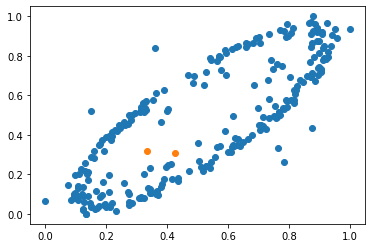

video  1
For n_clusters = 2 The average silhouette_score is : 0.32906416960444557
For n_clusters = 3 The average silhouette_score is : 0.3624164778352842
For n_clusters = 4 The average silhouette_score is : 0.3397349292923637
For n_clusters = 5 The average silhouette_score is : 0.31231692056571764
For n_clusters = 6 The average silhouette_score is : 0.27574310767332794
len 0
epochs 0
iter 0
iter 1
iter 2
len 1
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 207 207
no.of clusters:: 3
sizes of clusters:
.................ans.........................................
Beta 2.5732297902982744
Alpha 2.642460195061522
Theta nan
Beta 2.5732297902982744
Alpha 2.642460195061522
Theta nan
....................ans......................................
File_name 0.9738007766805222
Duration of the video: 58
..........................................................
.................ans.........................................
Beta 3.0397381645227517
Alpha 2.653419641086201
Theta 2.816957783949814

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


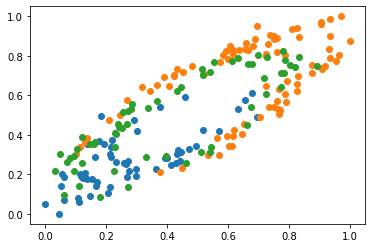

video  2
For n_clusters = 2 The average silhouette_score is : 0.33087282177302496
For n_clusters = 3 The average silhouette_score is : 0.32418826981599047
For n_clusters = 4 The average silhouette_score is : 0.32185002052947936
For n_clusters = 5 The average silhouette_score is : 0.34500834120475093
For n_clusters = 6 The average silhouette_score is : 0.35061832614007826
len 0
epochs 0
iter 0
iter 1
iter 2
len 1
epochs 0
iter 0
iter 1
iter 2
len 2
epochs 0
iter 0
iter 1
iter 2
len 3
epochs 0
iter 0
iter 1
iter 2
len 4
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 435 435
no.of clusters:: 6
sizes of clusters:
.................ans.........................................
Beta 2.2636132761428454
Alpha 2.0645694988944756
Theta nan
Beta 2.2636132761428454
Alpha 2.0645694988944756
Theta nan
....................ans......................................
File_name 1.0964093373242958
Duration of the video: 50
..........................................................
.................ans.

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


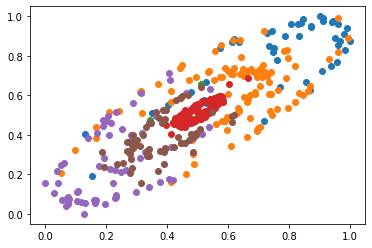

video  3
For n_clusters = 2 The average silhouette_score is : 0.18897962710629318
For n_clusters = 3 The average silhouette_score is : 0.18925883687120015
For n_clusters = 4 The average silhouette_score is : 0.20988370208367416
For n_clusters = 5 The average silhouette_score is : 0.19527488074922028
For n_clusters = 6 The average silhouette_score is : 0.22356935557288787
len 0
epochs 0
iter 0
iter 1
iter 2
len 1
epochs 0
iter 0
iter 1
iter 2
len 2
epochs 0
iter 0
iter 1
iter 2
len 3
epochs 0
iter 0
iter 1
iter 2
len 4
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 484 484
no.of clusters:: 6
sizes of clusters:
.................ans.........................................
Beta 2.3675535163310544
Alpha 2.619548934523168
Theta 2.4999146618517347
Beta 2.3675535163310544
Alpha 2.619548934523168
Theta 2.4999146618517347
....................ans......................................
File_name 0.9038019809933484
Duration of the video: 143
...................................................

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


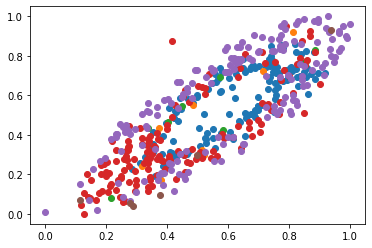

video  4
For n_clusters = 2 The average silhouette_score is : 0.09100172215879046
For n_clusters = 3 The average silhouette_score is : 0.0827316793941842
For n_clusters = 4 The average silhouette_score is : 0.07863953523090254
For n_clusters = 5 The average silhouette_score is : 0.08038835612036799
For n_clusters = 6 The average silhouette_score is : 0.060262374731673306
len 0
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 313 313
no.of clusters:: 2
sizes of clusters:
.................ans.........................................
Beta 2.996139160296987
Alpha 2.8287994654468673
Theta 3.3469024947423187
Beta 2.996139160296987
Alpha 2.8287994654468673
Theta 3.3469024947423187
....................ans......................................
File_name 1.0591557290978506
Duration of the video: 138
..........................................................
.................ans.........................................
Beta 3.0456976530139137
Alpha 3.095231074700529
Theta 3.012246923540727
Be

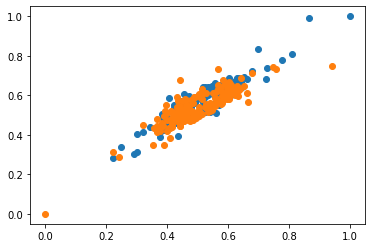

video  5
For n_clusters = 2 The average silhouette_score is : 0.29252016000454417
For n_clusters = 3 The average silhouette_score is : 0.26622801545935615
For n_clusters = 4 The average silhouette_score is : 0.27787581971778513
For n_clusters = 5 The average silhouette_score is : 0.26462184570037184
For n_clusters = 6 The average silhouette_score is : 0.24702737688721305
len 0
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 361 361
no.of clusters:: 2
sizes of clusters:
.................ans.........................................
Beta 2.834802408915918
Alpha 2.84864193031102
Theta 2.7389057730608304
Beta 2.834802408915918
Alpha 2.84864193031102
Theta 2.7389057730608304
....................ans......................................
File_name 0.9951417125305071
Duration of the video: 329
..........................................................
.................ans.........................................
Beta 2.765971328962708
Alpha nan
Theta nan
Beta 2.765971328962708
Alpha 1
Thet

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


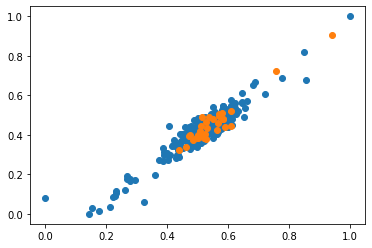

video  6
For n_clusters = 2 The average silhouette_score is : 0.7490924703522331
For n_clusters = 3 The average silhouette_score is : 0.34400507873238234
For n_clusters = 4 The average silhouette_score is : 0.31838790288717606
For n_clusters = 5 The average silhouette_score is : 0.2168795430146254
For n_clusters = 6 The average silhouette_score is : 0.248337853031173
len 0
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 318 318
no.of clusters:: 2
sizes of clusters:
.................ans.........................................
Beta 2.6223773770842715
Alpha nan
Theta nan
Beta 2.6223773770842715
Alpha 1
Theta nan
....................ans......................................
File_name 2.6223773770842715
Duration of the video: 31
..........................................................
.................ans.........................................
Beta 2.449190464762659
Alpha 2.5367216184936456
Theta 2.4339386808952246
Beta 2.449190464762659
Alpha 2.5367216184936456
Theta 2.4339386808

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


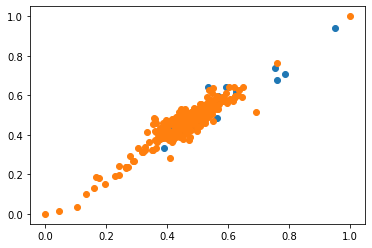

video  7
For n_clusters = 2 The average silhouette_score is : 0.47226506109402777
For n_clusters = 3 The average silhouette_score is : 0.4286781490955195
For n_clusters = 4 The average silhouette_score is : 0.4234677161643826
For n_clusters = 5 The average silhouette_score is : 0.052058237047484086
For n_clusters = 6 The average silhouette_score is : 0.049854938484320495
len 0
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 365 365
no.of clusters:: 2
sizes of clusters:
.................ans.........................................
Beta 2.576759049827466
Alpha 2.6932808607976613
Theta nan
Beta 2.576759049827466
Alpha 2.6932808607976613
Theta nan
....................ans......................................
File_name 0.9567361084890028
Duration of the video: 45
..........................................................
.................ans.........................................
Beta 2.4809922153804393
Alpha 2.402833668982046
Theta 2.3836504975901747
Beta 2.4809922153804393
Alpha 2.

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


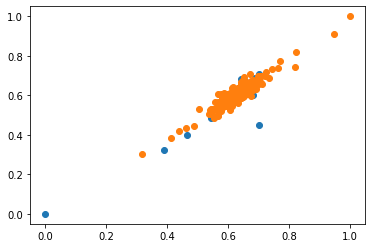

video  8
For n_clusters = 2 The average silhouette_score is : 0.07581473452596098
For n_clusters = 3 The average silhouette_score is : 0.06954857171227075
For n_clusters = 4 The average silhouette_score is : 0.08147786355778948
For n_clusters = 5 The average silhouette_score is : 0.0561414314189612
For n_clusters = 6 The average silhouette_score is : 0.06262875264539945
len 0
epochs 0
iter 0
iter 1
iter 2
len 1
epochs 0
iter 0
iter 1
iter 2
len 2
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 321 321
no.of clusters:: 4
sizes of clusters:
.................ans.........................................
Beta 3.496851547857498
Alpha 3.5778270225493376
Theta 4.014604955346665
Beta 3.496851547857498
Alpha 3.5778270225493376
Theta 4.014604955346665
....................ans......................................
File_name 0.9773674148634102
Duration of the video: 127
..........................................................
.................ans.........................................
Beta 

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


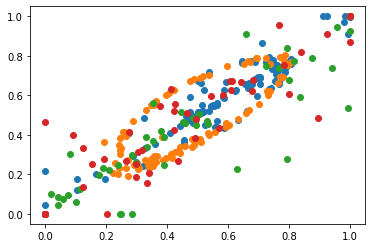

video  9
For n_clusters = 2 The average silhouette_score is : 0.27640739435202366
For n_clusters = 3 The average silhouette_score is : 0.2674815929102911
For n_clusters = 4 The average silhouette_score is : 0.2850934803218278
For n_clusters = 5 The average silhouette_score is : 0.3111581172113145
For n_clusters = 6 The average silhouette_score is : 0.2926348901256751
len 0
epochs 0
iter 0
iter 1
iter 2
len 1
epochs 0
iter 0
iter 1
iter 2
len 2
epochs 0
iter 0
iter 1
iter 2
len 3
epochs 0
iter 0
iter 1
iter 2
Duration of the video: 256 256
no.of clusters:: 5
sizes of clusters:
.................ans.........................................
Beta 2.5948475444954093
Alpha 2.326745253056352
Theta nan
Beta 2.5948475444954093
Alpha 2.326745253056352
Theta nan
....................ans......................................
File_name 1.1152263192916736
Duration of the video: 55
..........................................................
.................ans.........................................
B

C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shaw\AppData\Local\Continuum\anaconda3\envs\Demo\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


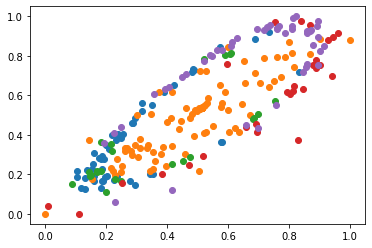

student 1
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1}
understanding level
[{0: 0.0, 1: 0.4251207729468599, 2: 0.5448275862068965, 3: 0.0, 4: 0.44089456869009586, 5: 0.0886426592797784, 6: 0.09748427672955975, 7: 0.8767123287671232, 8: 0.3146417445482866, 9: 0.81640625}]


In [2]:
import os
from numpy import nan
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
i=0
ccc=0
def normalise(X):
    for i in range(len(X[0])):
        v = X[:,i]
        X[:,i] = (v - v.min())/(v.max() - v.min())
    return X

user_data = []
user_level_understanding = []
for subdir, dirs, files in os.walk('D1_1'):
    print("user",i)
    j=0
    if i==0:
        i+=1
        continue
    labels = {}
    levels_und = {}
    attentive_sec = 0
    for file in files:
        print("video ",j)
        filepath = os.path.join(subdir, file)
        X = np.genfromtxt(filepath, delimiter=',')#,skip_header=None)
        
        X = normalise(X)
        #print(type(X))
        #print(X)
       
        y=0 # 0- not understood, 1 - understood
        #Silhouette coefficient to find optimal k value
        range_n_clusters = [2, 3, 4, 5, 6]
        optimalK = -1
        maxS = -1
        for n_clusters in range_n_clusters:

            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", silhouette_avg)

            if(silhouette_avg>maxS):
                maxS=silhouette_avg
                optimalK=n_clusters

        #cluster = ts_cluster()

        #algorithm = kmeans
        algorithm = bisecting_kmeans
        k = optimalK
        verbose = False
        max_iter = 3
        epochs = 1
        clusters = algorithm(X, optimalK, verbose=verbose, max_iter=max_iter, epochs=epochs)
        
        
        centroids=[]
        for c in clusters:
            if c is not None:
                centroids.append(np.mean(c,0))
        duration = len(X)      
        print("Duration of the video:",len(X),duration)
        print("no.of clusters::",len(clusters))
        print("sizes of clusters:")
        total=0
        attentive_sec=0
        for cluster in clusters:
            points = convert_to_2d_array(cluster)
            
            #print("nit",len(points))
            #print("nit",type(points))
            #print(points)
            X = points
            fs = 512  # Sampling rate (512 Hz)

            # Get real amplitudes of FFT (only in postive frequencies)
            fft_vals = np.absolute(np.fft.rfft(X))    #these are my fft values rfft returns only the part of the result that 
                                                  #corresponds to nonpositive frequences. (Avoids complex conjugaes) 
                                                  #faster and for plotting

            # Get frequencies for amplitudes in Hz
    
            fft_freq = np.fft.rfftfreq(len(X), 1.0 / fs)     # that might be fixed (window length n , and  sample spacing)
                                                        #inverse of the sampling rate   returns sample freq of length n .

            # Define EEG bands
            eeg_bands = {'Delta': (0, 4),
                        'Theta': (4, 8),
                        'Alpha': (8, 12),
                        'Beta': (12, 30),
                        'Gamma': (30, 45)}

            # Take the mean of the fft amplitude for each EEG band
            eeg_band_fft5 = dict()
            for band in eeg_bands:
                freq_ix = np.where((fft_freq >= eeg_bands[band][0]) &   #np.where is like asking "tell me where in this array, entries satisfy a given condition".
                            (fft_freq <= eeg_bands[band][1]))[0]    #for fft_frreq at all point where it satisfies it returns the index (in array)
                                                             #if fftfreq[np.where bla bla] will give values array
                eeg_band_fft5[band] = np.mean(fft_vals[freq_ix])
    
           # Plot the data (using pandas here cause it's easy)
            print(".................ans.........................................")
            print("Beta",eeg_band_fft5['Beta'])
            print("Alpha",eeg_band_fft5['Alpha'])
            print("Theta",eeg_band_fft5['Theta'])
            
            if np.isnan(eeg_band_fft5['Beta']):
                eeg_band_fft5['Beta'] =1 
            if np.isnan(eeg_band_fft5['Alpha']) :
                eeg_band_fft5['Alpha'] =1 
            print("Beta",eeg_band_fft5['Beta'])
            print("Alpha",eeg_band_fft5['Alpha'])
            print("Theta",eeg_band_fft5['Theta'])    
            print("....................ans......................................")
            print("File_name",(eeg_band_fft5['Beta']/eeg_band_fft5['Alpha']))
            print("Duration of the video:",len(X))
            print("..........................................................")
            attention_value= (eeg_band_fft5['Beta']/eeg_band_fft5['Alpha'])
            if ((eeg_band_fft5['Beta']/eeg_band_fft5['Alpha'])>1): 
                attentive_sec+= len(points)
                #total = total + attention_value * len(points)
        #print("attentive_sec",attentive_sec) 
        print("attentive_sec",attentive_sec)
               
        if (attentive_sec >= (duration*(3/5))):
            y=1
        labels[j] = y
        print(duration)
        level_und = attentive_sec/duration
        print(level_und)
        levels_und[j] = level_und
        visualize_clusters(clusters)     

        j+=1
    i=i+1
    user_data.append(labels)
    user_level_understanding.append(levels_und)

u=1
for user in user_data:
    print("student "+str(u))
#    for k,v in user.items():
#        if v == 0:
#            user[k]="No"
#        else:
#            user[k] = "Yes"
    print(user)
    u=u+1
print("understanding level")
print(user_level_understanding)

In [ ]:
import numpy as np
np.savetxt('All_with_cluster_B_1sec.csv', with_cluster_B_1sec, delimiter=",")